{'2002-2005': {'geo': ['../input/stat_Master_02_geo_s1.crs', '../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs'], 'gto': ['../input/stat_Master_02_gto_s1.crs', '../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs'], 'fol': ['../input/stat_Master_02_fol_s1.crs', '../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs']}, '2003-2006': {'geo': ['../input/stat_Master_03_geo_s1.crs', '../input/stat_Master_04_geo_s1.crs', '../input/stat_Master_05_geo_s1.crs', '../input/stat_Master_06_geo_s1.crs'], 'gto': ['../input/stat_Master_03_gto_s1.crs', '../input/stat_Master_04_gto_s1.crs', '../input/stat_Master_05_gto_s1.crs', '../input/stat_Master_06_gto_s1.crs'], 'fol': ['../input/stat_Master_03_fol_s1.crs', '../input/stat_Master_04_fol_s1.crs', '../input/stat_Master_05_fol_s1.crs', '../input/stat_Master_06_fol_s1.crs']}, '20

c:\Users\fionu\OneDrive\Dokumente\Daten Fiona\AIUB\Code\AIUB-Backup\clustering\scores.py:200: RuntimeWarning: invalid value encountered in sqrt
  stds[label] = tuple(np.sqrt(eigenvalues))


Best for 2016-2019: eps = 0.012, min_samples = 17, silhouette = -0.056

Running DBSCAN for Year Range: 2017-2020
Runtime for dbscan_clustering: 0.004026 seconds
Best for 2017-2020: eps = 0.012, min_samples = 17, silhouette = 0.078

Running DBSCAN for Year Range: 2018-2021
Runtime for dbscan_clustering: 0.021832 seconds
Best for 2018-2021: eps = 0.012, min_samples = 17, silhouette = 0.099

Running DBSCAN for Year Range: 2019-2022
Runtime for dbscan_clustering: 0.024681 seconds
Best for 2019-2022: eps = 0.012, min_samples = 17, silhouette = -0.241

Running DBSCAN for Year Range: 2020-2023
Runtime for dbscan_clustering: 0.030259 seconds
Best for 2020-2023: eps = 0.012, min_samples = 17, silhouette = -0.079


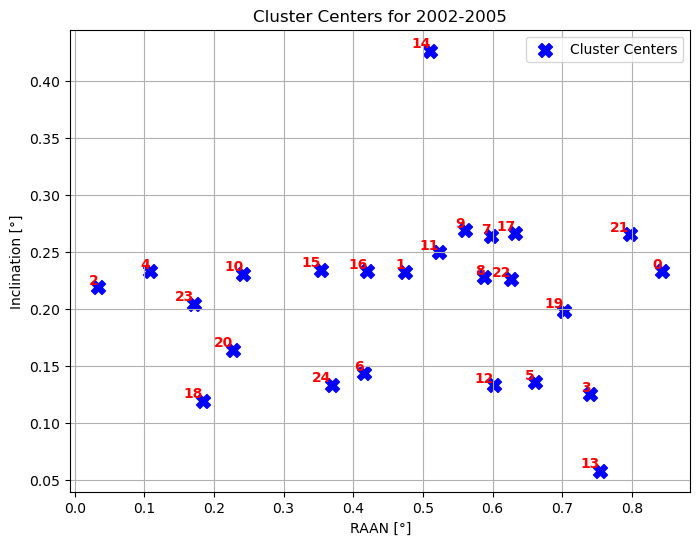

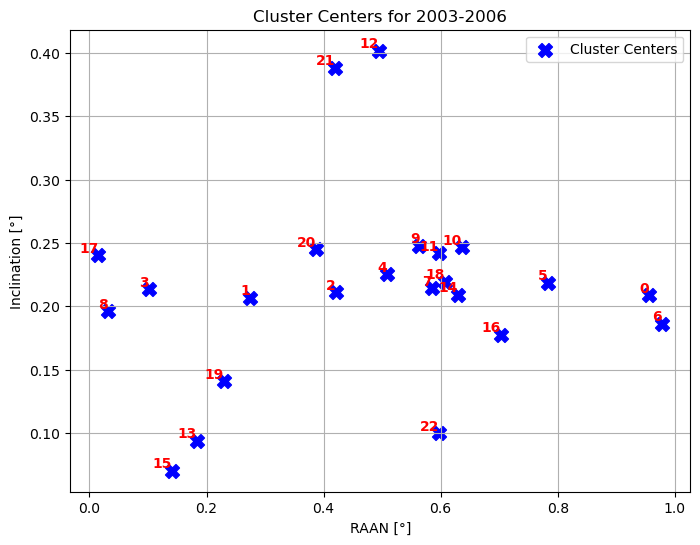

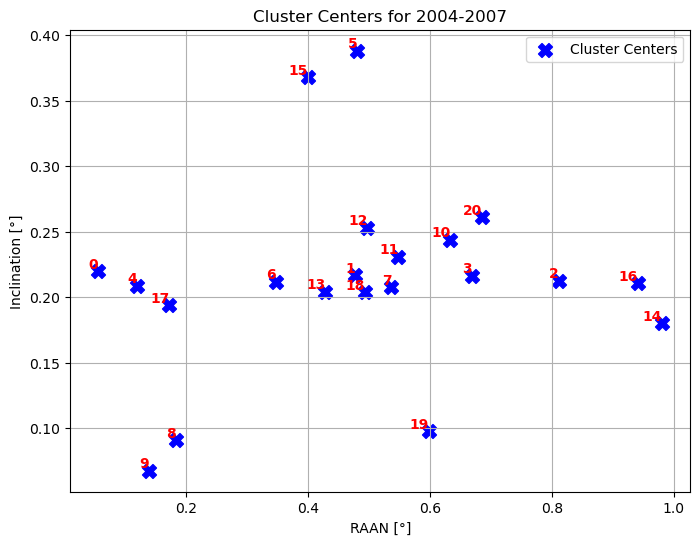

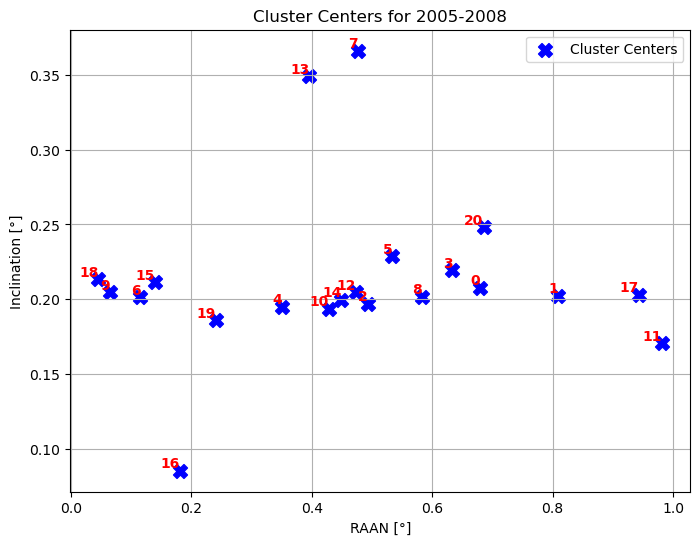

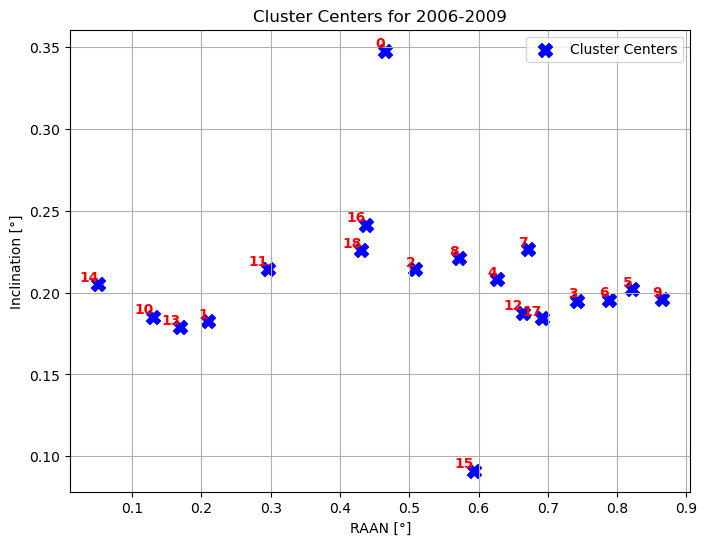

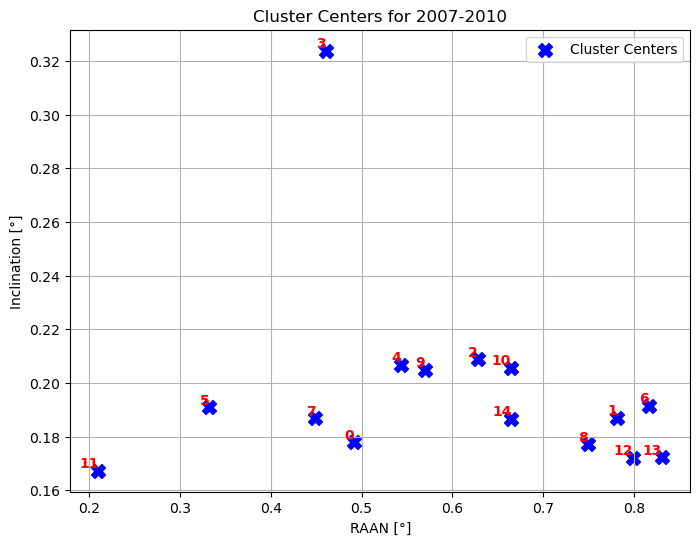

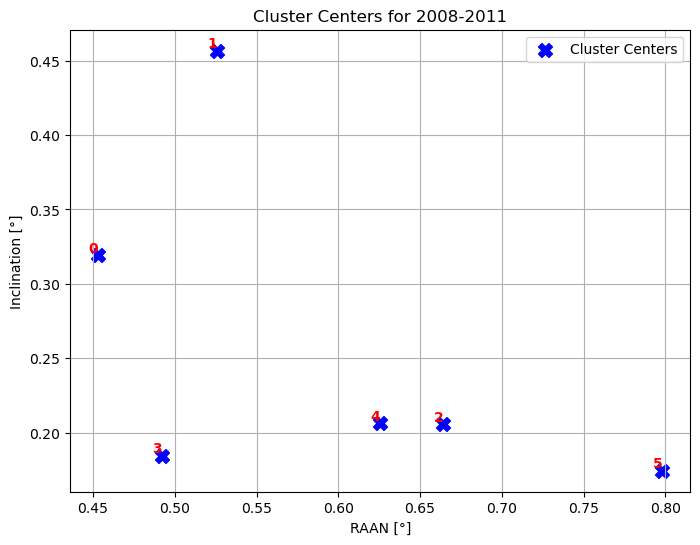

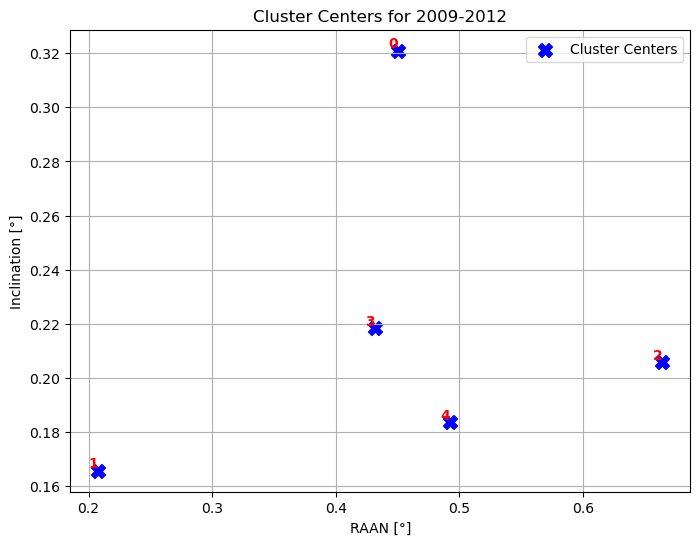

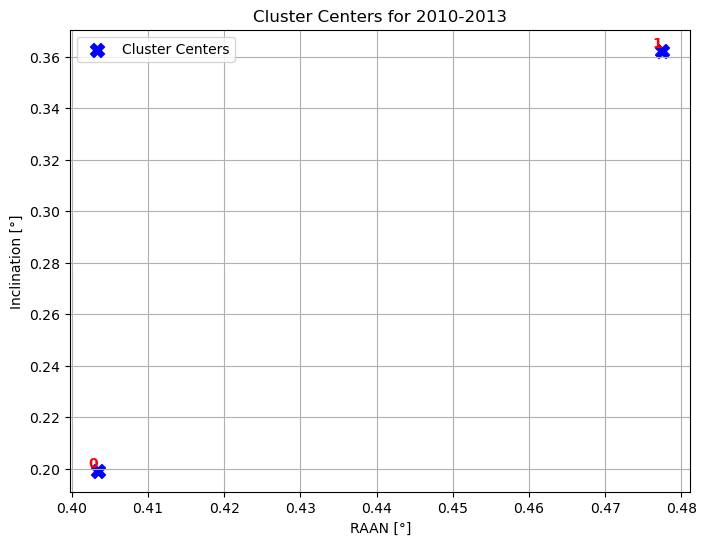

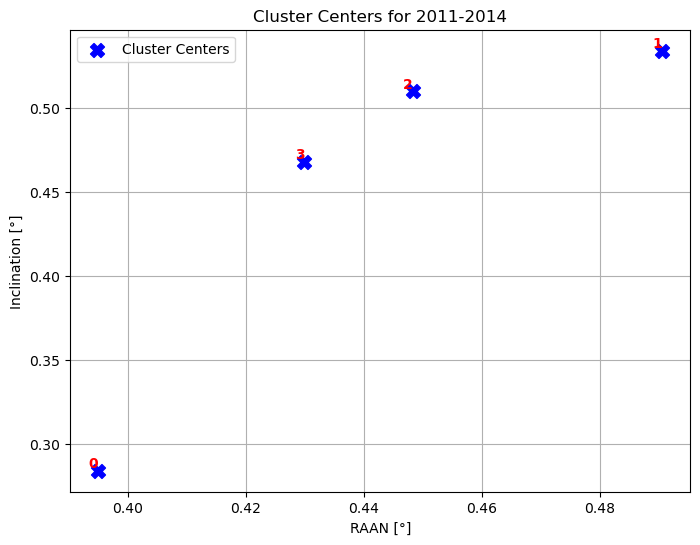

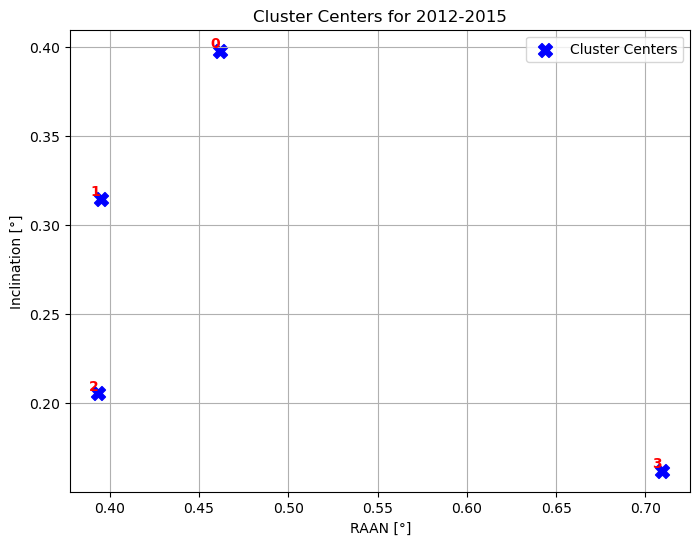

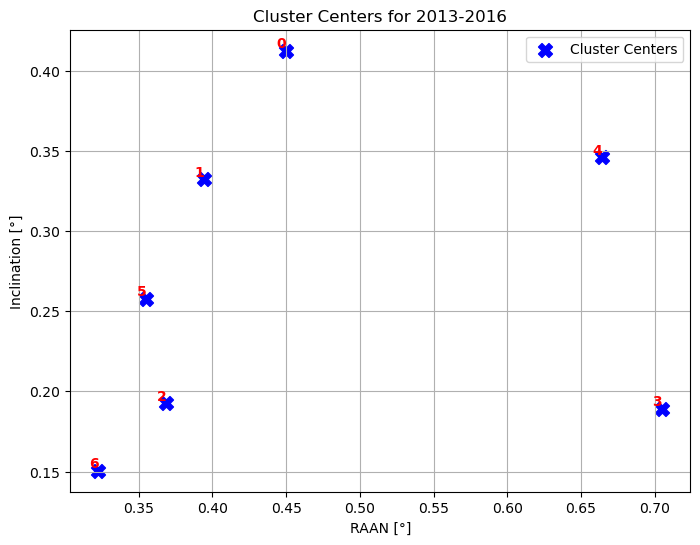

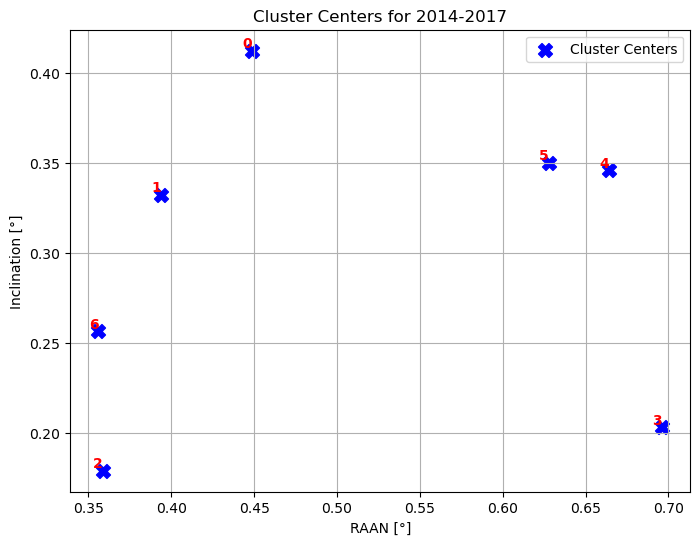

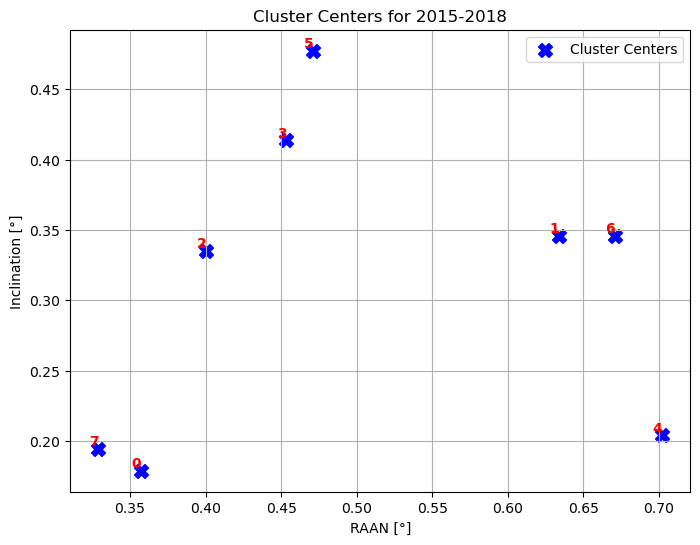

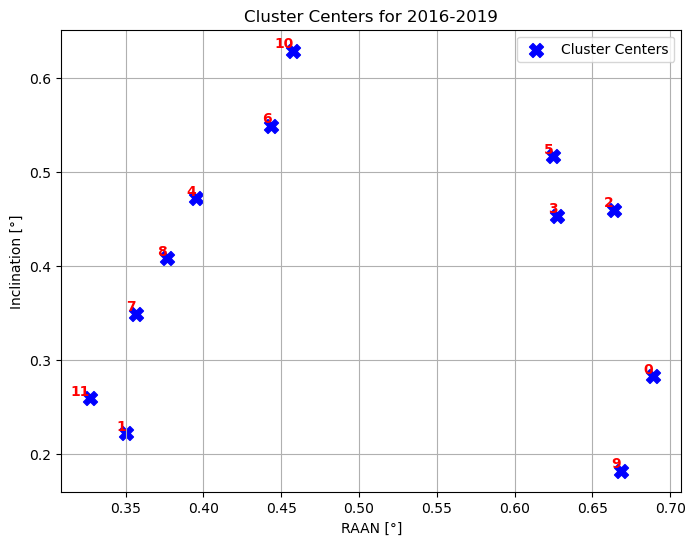

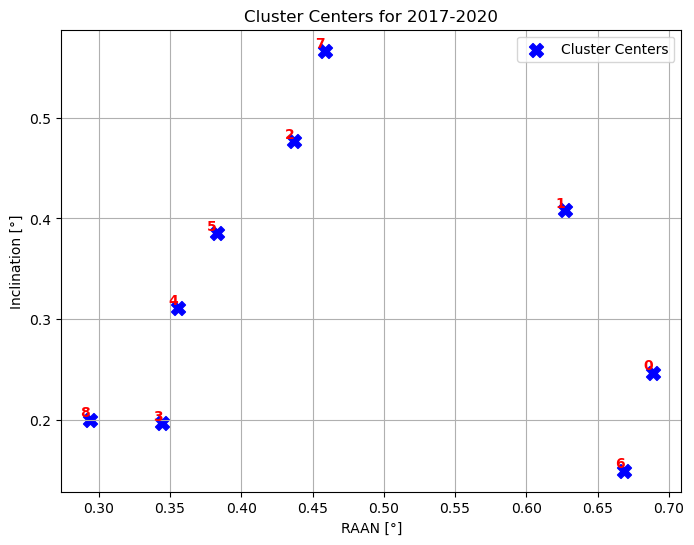

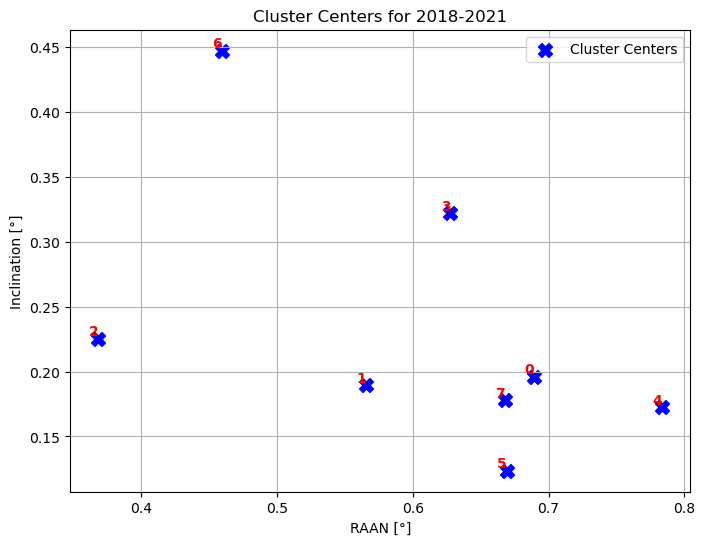

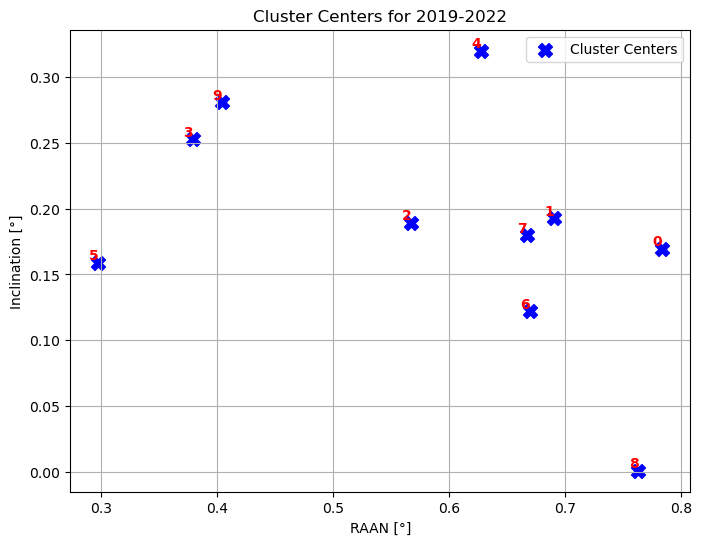

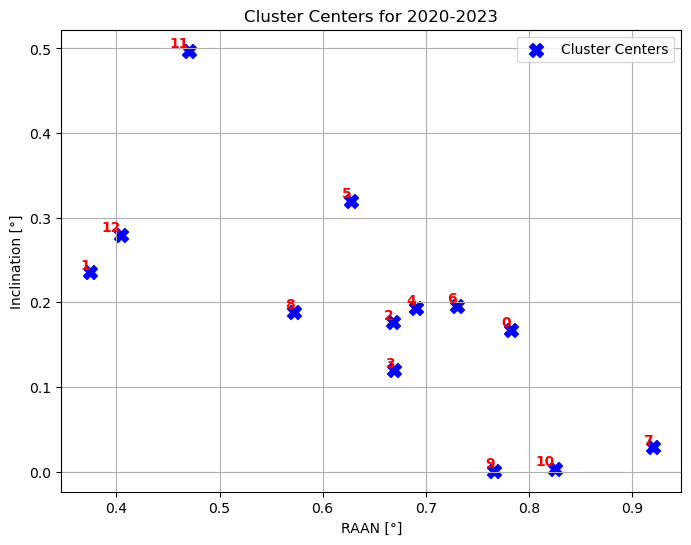

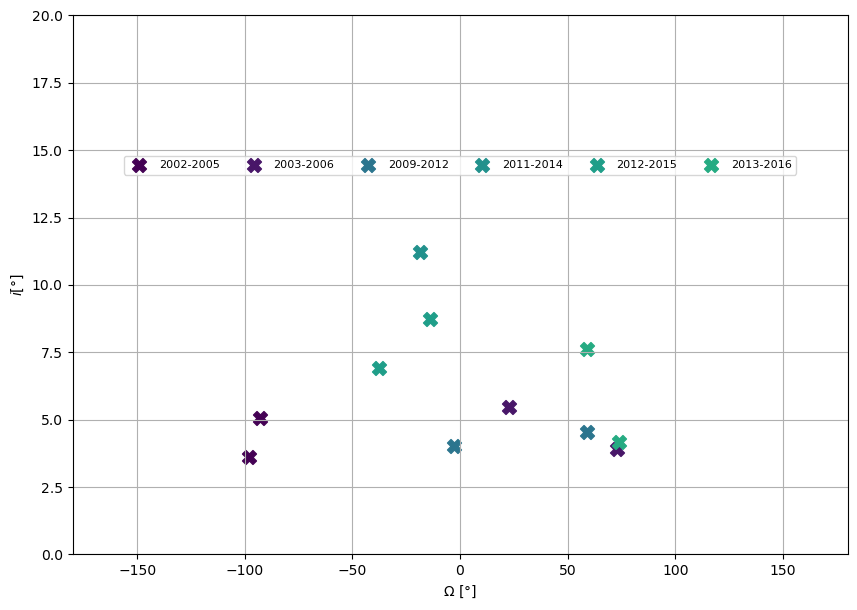

In [1]:
import cluster_data
from cluster_data import run_clustering, normalize_data, unnormalize
import numpy as np
import pandas as pd
import os
import cluster_plotter
from DBSCAN import dbscan_clustering
from cluster_plotter import ClusterPlotter
from clustering_utils import ClusterData
import matplotlib.pyplot as plt

standard_year_ranges = {
    f"{start}-{start + 3}": np.arange(start, start + 4)
    for start in [2002, 2006, 2010, 2014]
}
standard_year_ranges["2019-2023"] = np.arange(2019, 2024)
running_ranges = cluster_data.generate_running_year_ranges(2002, 2023, 4)

binned_data = cluster_data.bin_data_for_clustering(running_ranges, print_res=False)

plot_dir = "Images/dbscan_tails"
os.makedirs(plot_dir, exist_ok=True)
cluster_plotter.clear_directory(plot_dir)

results_per_year_range = {}
cluster_centers_dict = {}  # Stores cluster centers per year range

for cluster_data, year_range in binned_data:  
    print(f"\nRunning DBSCAN for Year Range: {year_range}")

    data_array = np.array([cluster_data.inc, cluster_data.raan]).T
    normalized_data, data_min, data_max = normalize_data(data_array)

    eps_values = [0.012]
    min_samples_values = [17]
    
    best_result = None
    best_score = float('-inf')
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            result_dbscan, time_dbscan, n_clusters_dbscan, points_per_cluster_dbscan, metrics_dbscan = run_clustering(
                dbscan_clustering, "DBSCAN", normalized_data, data_min, data_max, plot=False, eps=eps, min_samples=min_samples
            )
            
            silhouette_score = metrics_dbscan[3] if metrics_dbscan and isinstance(metrics_dbscan[3], (int, float)) else None
            noise_points = np.sum(result_dbscan.labels == -1)

            if silhouette_score is not None and silhouette_score > best_score:
                best_score = silhouette_score
                best_result = {
                    "eps": eps,
                    "min_samples": min_samples,
                    "runtime": time_dbscan,
                    "clusters": n_clusters_dbscan,
                    "points_per_cluster": points_per_cluster_dbscan,
                    "noise_points": noise_points,
                    "metrics": metrics_dbscan,
                    "result_dbscan": result_dbscan
                }

    if best_result:
        unnormalized_data, _ = unnormalize(best_result["result_dbscan"].data, None, data_min, data_max)
        
        results_per_year_range[year_range] = best_result
        print(f"Best for {year_range}: eps = {best_result['eps']}, min_samples = {best_result['min_samples']}, silhouette = {best_score:.3f}")

        # Store cluster centers
        if hasattr(best_result["result_dbscan"], "cluster_centers"):
            cluster_centers_dict[year_range] = best_result["result_dbscan"].cluster_centers

def plot_cluster_centers_separate(cluster_centers_dict):
    for year_range, centers in cluster_centers_dict.items():
        if centers is None:
            continue
        
        plt.figure(figsize=(8, 6))
        plt.scatter(centers[:, 1], centers[:, 0], color='blue', marker='X', s=100, label="Cluster Centers")
        
        for idx, (x, y) in enumerate(centers):
            plt.text(y, x, str(idx), fontsize=10, ha='right', va='bottom', color='red', fontweight='bold')

        plt.xlabel("RAAN [°]")
        plt.ylabel("Inclination [°]")
        plt.title(f"Cluster Centers for {year_range}")
        plt.legend()
        plt.grid(True)
        plt.show()

plot_cluster_centers_separate(cluster_centers_dict)

# Manual selection of clusters
selected_clusters = {}  

def select_cluster(year_range, cluster_idx):
    if year_range in cluster_centers_dict and cluster_idx < len(cluster_centers_dict[year_range]):
        selected_clusters[year_range] = cluster_centers_dict[year_range][cluster_idx]
        print(f"Selected cluster {cluster_idx} from {year_range}: {selected_clusters[year_range]}")
    else:
        print("Invalid selection. Check year range and cluster index.")

def plot_cluster_centers_separate(cluster_centers_dict):
    for year_range, centers in cluster_centers_dict.items():
        if centers is None:
            continue
        
        plt.figure(figsize=(8, 6))
        plt.scatter(centers[:, 1], centers[:, 0], color='blue', marker='X', s=100, label="Cluster Centers")
        
        for idx, (x, y) in enumerate(centers):
            plt.text(y, x, str(idx), fontsize=10, ha='left', va='bottom', color='red', fontweight='bold')

        plt.xlabel("RAAN [°]")
        plt.ylabel("Inclination [°]")
        plt.title(f"Cluster Centers for {year_range}")
        plt.legend()
        plt.grid(True)
        plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Fixing the dictionary syntax
selected_clusters = {
    "2002-2005": [10, 20],
    "2003-2006": [16, 9],
    "2004-2007": [22, 13],
    "2005-2008": [20, 15, 35],
    "2006-2009": [17, 33, 31, 35, 34],
    "2007-2010": [21, 18, 25],
    "2008-2011": [4, 6],
    "2009-2012": [2, 4],
    "2010-2013": [3, 2],
    "2011-2014": [2],
    "2012-2015": [0, 1],
    "2013-2016": [3, 4],
    "2014-2017": [3, 10],
    "2015-2018": [13, 8, 14],
    "2016-2019": [16, 7],
    "2017-2020": [16],
    "2018-2021": [18, 15, 9, 7],
    "2019-2022": [7, 4, 15],
    "2020-2023": [26, 6, 14, 27]
}

# Function to plot the centroids of selected clusters
def plot_selected_cluster_centers(cluster_centers_all, selected_clusters, data_min, data_max):
    plt.figure(figsize=(10, 7))
    colors = plt.cm.viridis(np.linspace(0, 1, len(selected_clusters)))  # Different color per year range

    scale = data_max - data_min

    for i, (year_range, indices) in enumerate(selected_clusters.items()):
        if not indices or year_range not in cluster_centers_all:
            continue

        centers_normed = cluster_centers_all[year_range]

        # Ensure indices are valid
        if np.max(indices) >= len(centers_normed):
            print(f"Warning: Invalid index in {year_range}")
            continue

        selected = centers_normed[indices]

        # Unnormalize
        selected_unnormed = selected * scale + data_min

        # Wrap RAAN to [-180, 180]
        selected_unnormed[:, 1] = (selected_unnormed[:, 1] + 180) % 360 - 180
        # Clamp inclination to [0, 22]
        selected_unnormed[:, 0] = np.clip(selected_unnormed[:, 0], 0, 22)

        color = colors[i]
        plt.scatter(selected_unnormed[:, 1], selected_unnormed[:, 0], color=color, marker='X', s=100, label=year_range)

    plt.xlabel("$\\Omega$ [°]")
    plt.ylabel("$i$[°]")
    #plt.title("Moving tail clusters with overlapping year binnings")
    plt.xlim(-180, 180)
    plt.ylim(0, 20)
    
    # Move the legend inside the figure, horizontally, with two rows
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 0.75), ncol=6, fontsize=8)

    plt.grid(True)
    plt.show()


# Call the function with the actual cluster centers from K-Means
centers = cluster_centers_dict
#print(centers)
data_min = np.array([0.0, -180.0])      # inclination, RAAN
data_max = np.array([22.0, 180.0])

plot_selected_cluster_centers(cluster_centers_dict, selected_clusters, data_min, data_max)